#### https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
#### https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html
#### https://github.com/zjor/inverted-pendulum/blob/master/python/free-pendulum.py
#### https://riptutorial.com/matplotlib/example/23558/basic-animation-with-funcanimation

# Bewegungsgleichung freies, gedämpftes Pendel:
$ \ddot\theta(t) + \frac{d}{m \cdot l^2} \cdot \dot\theta(t) + \frac{g}{l} \cdot \sin(\theta(t)) = 0 $

### Systemgleichungen:
$ \dot\theta(t) = \omega(t) $

$ \dot\omega(t) = - \frac{d}{m \cdot l^2} \cdot \omega(t) - \frac{g}{l} \cdot \sin(\theta(t)) $

### State Vector y:

$ y(t) = \begin{vmatrix}
\theta(t)\\
\omega(t)
\end{vmatrix}$

In [1]:
import sympy as smp
import sympy.physics.mechanics as mech
mech.init_vprinting()
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import FloatSlider, interact_manual

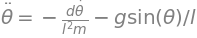

In [2]:
t, g, l, m, d = smp.symbols('t, g l m d')

theta = smp.Function('theta')(t)
theta_d = theta.diff(t)
theta_dd = theta_d.diff(t)

T = smp.Rational(1,2) * m * (l * theta_d)**2
V = m * g * (- l * smp.cos(theta))
L = T - V

LE = smp.diff(smp.diff(L, theta_d) ,t) - smp.diff(L, theta)
LE = smp.Eq(LE, -d * theta_d)

solution = smp.solve(LE, theta_dd)
display(smp.Eq(theta_dd, solution[0]))

In [3]:
dthetadt = smp.lambdify(theta_d, theta_d)
domegadt = smp.lambdify((t, theta, theta_d, g, l, m, d), solution[0])

def dSdt(S, t, g, l, m, d):
    theta, omega = S
    return [
        dthetadt(omega),
        domegadt(t, theta, omega, g, l, m, d)
    ]

In [4]:



# Zeitbereich
t1 = 15
frames = 200
t = np.linspace(0,t1,frames)
    
# Slider für Eingabewerte
damping = FloatSlider(value=0.42,min=0,max=1,step=0.01,description='$d$')
length = FloatSlider(value=1.0,min=0.5,max=3.0,step=0.5,description='$l$')
mass = FloatSlider(value=1.00,min=0.5,max=3.0,step=0.5,description='$m$')
theta_0 = FloatSlider(value=3.14,min=0,max=np.pi,step=0.01,description=r'$\theta_0$')

def interaction(d, l, m, t0):
    
    S0 = [t0, 0.0]

    ans = odeint(dSdt, y0=S0, t=t, args=(9.81, l, m, d))
    theta = ans[:, 0]
    omega = ans[:, 1]

    plt.plot(t, theta, label=r'$\theta(t)\enspace[rad]$')
    plt.plot(t, omega, label=r'$\omega(t)\enspace[\frac{rad}{s}]$')
    plt.legend(loc='best')
    
interactive_plot = interact_manual(interaction, d=damping, l=length, m=mass, t0=theta_0)

interactive(children=(FloatSlider(value=0.42, description='$d$', max=1.0, step=0.01), FloatSlider(value=1.0, d…

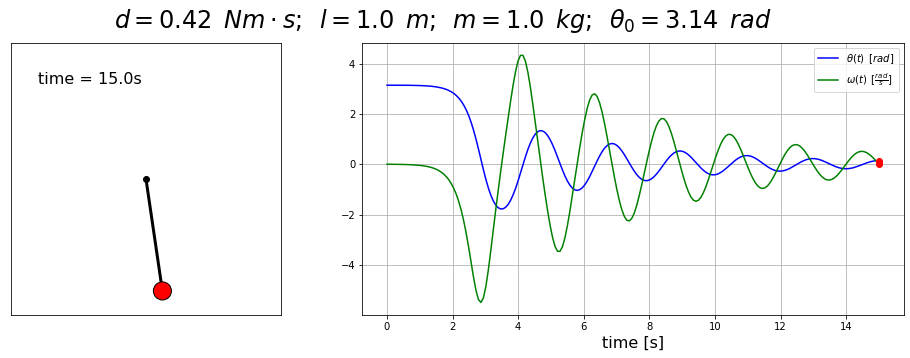

In [5]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
from matplotlib.animation import PillowWriter
%matplotlib inline

# Slider Werte
l = length.value
d = damping.value
m = mass.value
t0 = theta_0.value

S0 = [t0, 0.0]

# ODE neu berechnen
solution = odeint(dSdt, y0=S0, t=t, args=(9.81, l, m, d))

# Kartesischen Koordinaten der Pendelmasse 
x = l * np.sin(solution[:, 0])
y = - l * np.cos(solution[:, 0])

# Animation Figure vorbereiten
fig = plt.figure(figsize=(16, 5))
gs = GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])
string = r"$d=%s\enspaceNm\cdot s;\enspacel=%s\enspacem;\enspacem=%s\enspacekg;\enspace\theta_0=%s\enspacerad$"%(d,l,m,t0)
fig.suptitle(string, fontsize=24)

# Pendel Animation Plot
movement = fig.add_subplot(gs[0, 0], autoscale_on=False, xlim=(-l*1.2, l*1.2), ylim=(-l*1.2, l*1.2))
movement.get_xaxis().set_ticks([]) 
movement.get_yaxis().set_ticks([]) 

# Pendelmasse
circle = plt.Circle((0,0), 0.08, fc='r', zorder=3, edgecolor='k')
circle = movement.add_patch(circle)

# Pendelstab
line, = movement.plot([], [], 'o-', color='k',lw=3)

# Zeitlabel
time_template = 'time = %.1fs'
time_text = movement.text(0.1, 0.85, '', fontsize=16, transform=movement.transAxes)

# Zeitverlauf Animation Plot
timeline = fig.add_subplot(gs[:, 1])
timeline.plot(t, solution[:, 0], 'b', label=r'$\theta(t)\enspace[rad]$')
timeline.plot(t, solution[:, 1], 'g', label=r'$\omega(t)\enspace[\frac{rad}{s}]$')
timeline.set_xlabel('time [s]', fontsize=16)
timeline.legend(loc='best')
timeline.grid()

# Pendelmasse im Zeitverlauf
theta_point, = timeline.plot([], [], 'o-', color='r', lw=3)
omega_point, = timeline.plot([], [], 'o-', color='r', lw=3)


def animate(i):
    
    # Movement
    line.set_data([0, x[i]], [0, y[i]])  
    circle.set_center((x[i], y[i]))
    time_text.set_text(time_template % (t[i]))
    
    # Timeline
    theta_point.set_data(t[i], solution[i, 0])
    omega_point.set_data(t[i], solution[i, 1])
    return line, time_text


#ani = animation.FuncAnimation(fig, animate, frames=len(t), blit=True)
#ani.save('Pendulum.gif', writer='pillow', fps=frames/t1, dpi=180)